# Regression

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F


# Import models and training functions
from models import ConvNet, FFNet
from training import train_epochs,  kf_train_epochs
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

#Import sys
import sys

## Data generation

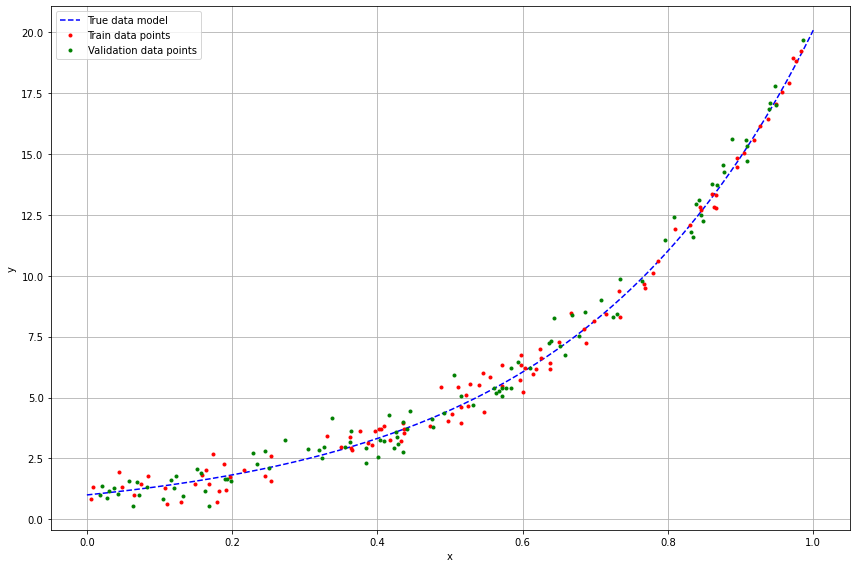

In [70]:
def exp_model(x, alpha, beta, noise_std=0):
    """
    INPUT
        x: x vector
        alpha: consant 
        beta: constant
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    noise = np.random.randn(len(x)) * noise_std
    return alpha*np.exp(beta*x) + noise

alpha = 1.0
beta = 3.0
noise_std = 0.5
np.random.seed(4)

### Train data
num_train_points = 100
x_train = np.random.rand(num_train_points)
y_train = exp_model(x_train, alpha, beta, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    
### Validation data
num_val_points = 100
x_val = np.random.rand(num_val_points)
y_val = exp_model(x_val, alpha, beta, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))

### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, exp_model(x_highres, alpha, beta), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Dataset and dataloader

### Dataset

In [71]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.transform = transform
        
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
            
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
            # Now self.data contains all our dataset.
            # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [72]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    


In [73]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader


In [74]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=True, num_workers=0)

## Training

In [75]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Stochastic Gradient Descent

In [76]:
# Define the network
layers_sizes = [1, 10, 10, 10, 1]
net_name = "FFNet_sgd.torch"

parameters = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "drop_p" : 0.1
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [77]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.0, weight_decay = 0.0)


In [78]:
# Training
max_num_epochs = 500
early_stopping = False
train_loss_sgd, val_loss_sgd = train_epochs(net, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)



  0%|          | 0/500 [00:00<?, ?it/s]

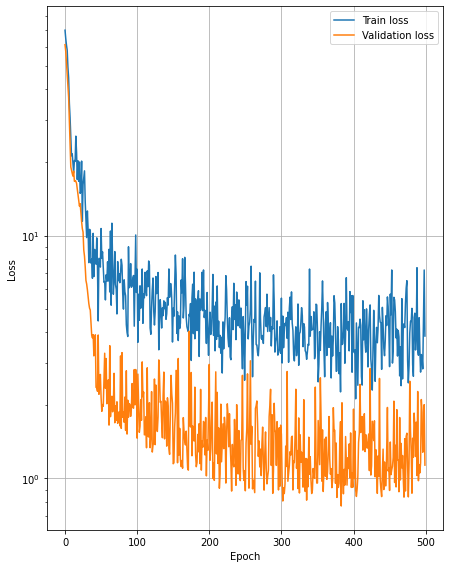

In [79]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgd, label='Train loss')
ax1.semilogy(val_loss_sgd, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

In [80]:
### Save network parameters

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,net_name)


### SGD with momentum

In [81]:
# Define the network
layers_sizes = [1, 10, 10, 10, 1]
net_name = "FFNet_sgdmom.torch"


parameters = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "drop_p" : 0.1
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [82]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0)

In [83]:
# Training
max_num_epochs = 500
early_stopping = False
train_loss_sgdmom, val_loss_sgdmom = train_epochs(net, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/500 [00:00<?, ?it/s]

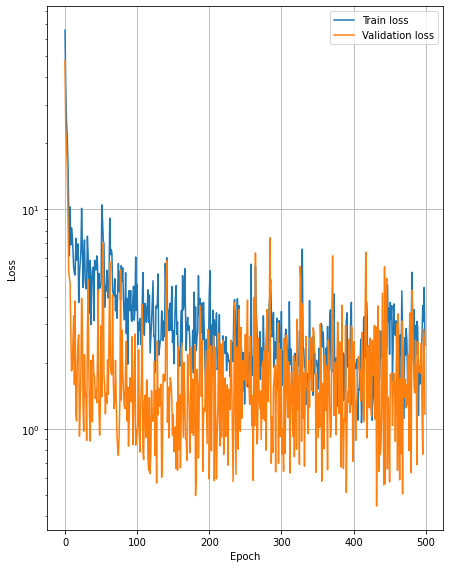

In [84]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgdmom, label='Train loss')
ax1.semilogy(val_loss_sgdmom, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

In [85]:
### Save network parameters

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,net_name)

### RMSprop

In [90]:
# Define the network
layers_sizes = [1, 10,10,10, 1]
net_name = "FFNet_rmsprop.torch"

parameters = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "drop_p" : 0.1
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [91]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.RMSprop(net.parameters(), lr = 0.001, momentum = 0.0, weight_decay = 0.0)

In [92]:
# Training
max_num_epochs = 1000
early_stopping = False
train_loss_rmsprop, val_loss_rmsprop = train_epochs(net, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/1000 [00:00<?, ?it/s]

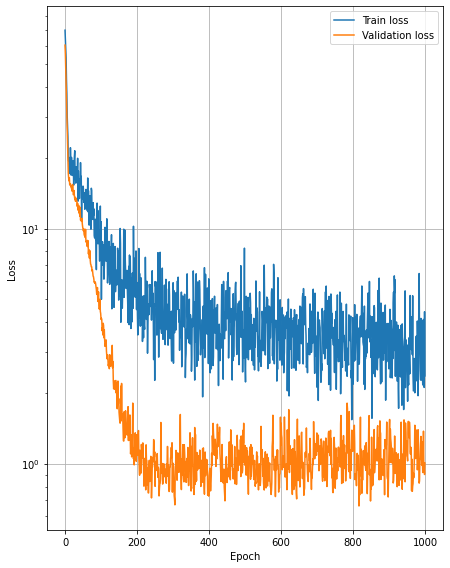

In [93]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_rmsprop, label='Train loss')
ax1.semilogy(val_loss_rmsprop, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

In [52]:
### Save network parameters


### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,net_name)

### Adam

In [94]:
# Define the network
layers_sizes = [1, 10,10,10, 1]
net_name = "FFNet_adam.torch"

parameters = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "drop_p" : 0.1
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [95]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)

In [96]:
# Training
max_num_epochs = 1000
early_stopping = False
train_loss_adam, val_loss_adam = train_epochs(net, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/1000 [00:00<?, ?it/s]

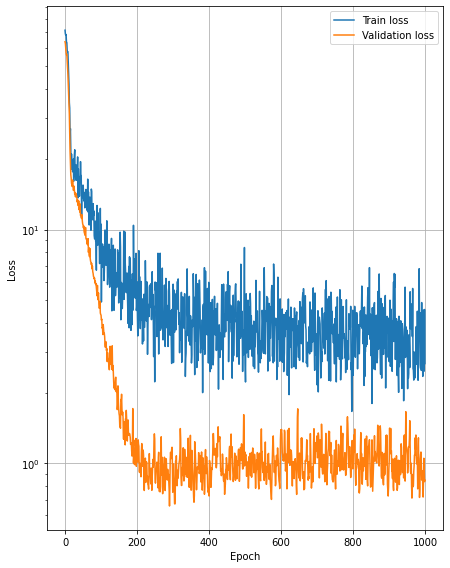

In [97]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adam, label='Train loss')
ax1.semilogy(val_loss_adam, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

In [98]:
### Save network parameters

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,net_name)

### Comparison

### Adam with k-fold cross validation

In [99]:
# Define the network
layers_sizes = [1, 10,10,10, 1]

parameters = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "drop_p" : 0.1
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Dropout(p=0.1, inplace=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0.1, inplace=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Dropout(p=0.1, inplace=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [100]:
# K-fold cross validation training
max_num_epochs = 1000
early_stopping = False
train_loss_log, val_loss_log = kf_train_epochs(net, device, k_fold = 5, batch_size = 4, dataset, max_number_epochs, early_stopping = early_stopping)



SyntaxError: positional argument follows keyword argument (<ipython-input-100-5489feedeaea>, line 4)

In [ ]:
### Plot k-fold losses

# Take average and std deviation losses at each epoch
mean_train_log = np.array([np.mean(train_loss_log[i]) for i in range(len(train_loss_log))])
std_train_log = np.array([np.std(train_loss_log[i]) for i in range(len(train_loss_log))])
mean_val_log = np.array([np.mean(val_loss_log[i]) for i in range(len(val_loss_log))])
std_val_log = np.array([np.std(val_loss_log[i]) for i in range(len(val_loss_log))])

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(mean_train_log, c = "b", label='Train loss')
ax1.fill_between(np.array(range(max_num_epochs)), mean_train_log-std_train_log, mean_train_log+std_train_log, color = "r")
#ax1.semilogy(mean_val_log, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

## Network Analysis

In [101]:
### Load network state
net_name = "FFNet_adam.torch"

# Load the state dict previously saved
net_dict = torch.load(net_name)
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = FFNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

In [102]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
true_model = exp_model(x_vec.cpu().numpy(), alpha, beta).squeeze()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


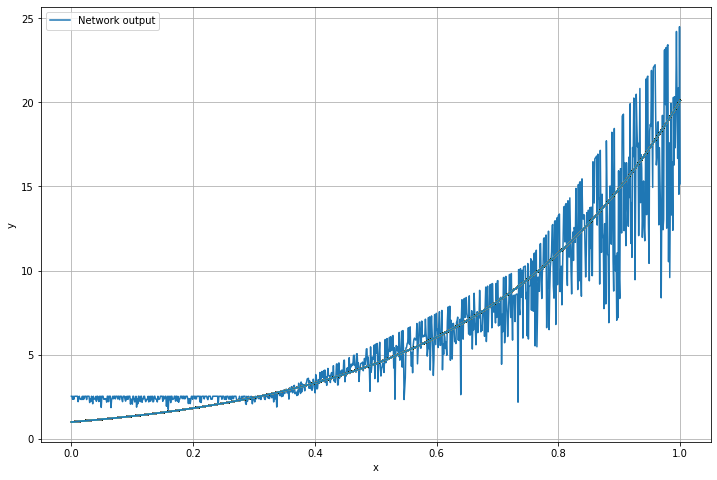

In [103]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()